# Améliorez le produit IA de votre start-up

In [1]:
### basic libs
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import warnings
# api
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
# text 
from nltk.stem.snowball import EnglishStemmer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# image
import tensorflow as tf

warnings.simplefilter(action='ignore', category=FutureWarning)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

debug = 1
    

### API queries

In [2]:
with open("api.key", "r") as f:
    api_key = f.readline()


header = {'Authorization': f'bearer {api_key}',
         'Content-Type': 'application/json'}

# Select your transport with a defined url endpoint
transport = RequestsHTTPTransport(url="https://api.yelp.com/v3/graphql", headers=header, use_json=True)

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)


In [3]:
def get_new_reviews(city):

    df_reviews = pd.DataFrame(columns=['text', 'rating'])
    
    offset = 50
    
    for chunk in range(4):
        query = '''
        {
          search(term:"restaurants",
                 limit : 50,
                 offset: '''+str(offset*chunk)+''',
                 location:"''' + city + '''") {
            business {
              reviews {
                text
                rating
              }
            }
          }
        }
        '''
        query = gql(query)
        result = client.execute(query)
    
        for business in result["search"]["business"]:
            for review in business["reviews"]:
                df_reviews = df_reviews.append(review, ignore_index=True)
                
    df_reviews = df_reviews.dropna()

    df_reviews.to_csv('new_reviews.csv')
    
    print(f"Got {df_reviews.shape[0]} reviews")
    
    print(df_reviews.head())
    
# get_new_reviews("san francisco")

### Comments analysis

In [4]:
if debug:
    nrows = 100000
else:
    nrows = None

filename = './preprocessed_reviews.csv'

comments = pd.read_csv(filename, nrows=nrows)

comments.head()

,tokenized_text
0,marriott renaiss marriott huge desk atrium sta...
1,cool chill bunch neanderth bouncer hop steroid...
2,set perfect adequ dine chain chili victoria st...
3,correct crappi inconsist gone hill steadili 9
4,bolt follow fanni fabric fanni select fabric l...


In [5]:
n_topics = 10

vectoriser = CountVectorizer(max_df=.6, min_df=10, max_features=100)
vectorized = vectoriser.fit_transform(comments["tokenized_text"].to_list())

lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=42).fit(vectorized)


In [6]:
def display_topics(model, feature_names, ntw): # do multiple runs and hyperparameters optimization
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-ntw-1:-1]]))

n_top_words = 10
display_topics(lda, vectoriser.get_feature_names(), n_top_words)

Topic 0:
pizza burger hair cut appoint kitchen unfortun apolog short whole
Topic 1:
card deal job fix min famili guess late ladi notic
Topic 2:
park beer tip everyon decent outsid okay quit bring usual
Topic 3:
lunch rice meat roll piec fish steak okay bread happi
Topic 4:
waiter item buy shop option portion quick apolog appet thank
Topic 5:
sat parti cost extra soup dine miss saw oh suppos
Topic 6:
hotel drive free kid nail insid sushi dirti outsid far
Topic 7:
salad plate hot husband hous special enjoy bland lack fresh
Topic 8:
name aw taco pleas read bartend sorri given overal oh
Topic 9:
sandwich coffe reserv slow girl counter quit mean sign usual


In [7]:
features_names = vectoriser.get_feature_names()

In [8]:
words_df = pd.DataFrame(columns=features_names, data=vectorized.toarray())
for col_name in features_names:
    words_df[col_name] = words_df[col_name].astype('bool')
words_df.head()

,absolut,ago,apolog,appet,appoint,aw,bartend,basic,beer,bland,...,steak,suppos,sushi,taco,thank,tip,unfortun,usual,waiter,whole
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Picture analysis

In [9]:
nrows = 32768

batch_size = 16

steps_per_epoch = nrows // batch_size

AUTOTUNE = tf.data.AUTOTUNE

In [10]:
def get_path(name):
    return os.path.join("preprocessed_imgs", f"{name}.jpg")

def load_img(path, tgt):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    tgt = tf.reshape(tgt, [1])
    return img, tgt

<AxesSubplot:xlabel='label', ylabel='Count'>

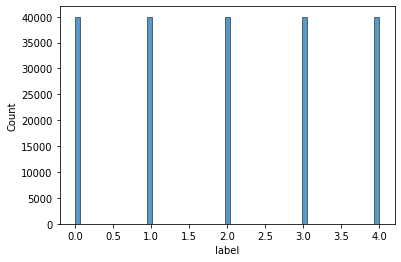

In [13]:
pictures = pd.read_json("photos.json", lines=True)[["photo_id", "label"]]
pictures["path"] = pictures["photo_id"].apply(get_path)
pictures = pictures[["path", "label"]]
pictures = pictures.sample(frac=1) # shuffle
pictures["label"] = pictures["label"].apply(lambda x:  {'interior': 0, 'outside': 1, 'menu': 2, 'food': 3, 'drink': 4}[x])
sns.histplot(x=pictures["label"])

In [14]:
train_df = pictures.head(nrows)
pictures = pictures.tail(pictures.shape[0] - nrows)
test_df = pictures.head(nrows)

In [15]:
def set_shapes(image, label):
    image.set_shape((224, 224, 3))
    return image, label

BUFFER_SIZE = 1000
# make tf dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_df["path"].values, tf.cast(train_df["label"].values, tf.int32))).shuffle(BUFFER_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_df["path"].values, tf.cast(test_df["label"].values, tf.int32))).shuffle(BUFFER_SIZE)
# load imgs from path
train_ds = train_ds.map(load_img, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(load_img, num_parallel_calls=AUTOTUNE)
# set imgs shape
train_ds = train_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
# preprocess datasets
train_ds = train_ds.repeat()
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.repeat()
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
def get_pred():
    model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    x = model.output
    predictions = tf.keras.layers.Flatten()(x)
    new_model = tf.keras.Model(inputs=model.input, outputs=predictions)
    print(new_model.summary())

    img = test_ds.take(1)
    pred = new_model.predict(img)
    
    return pred
    
# pred = get_pred()

# print(np.shape(pred))

In [17]:
def train_model():
    model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    predictions = tf.keras.layers.Dense(5, activation='softmax')(x)
    new_model = tf.keras.Model(inputs=model.input, outputs=predictions)
    for layer in model.layers[:5]:
        layer.trainable = False
    new_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
    
    print(new_model.summary())
    
    model_info = new_model.fit(train_ds, batch_size=batch_size, epochs=10, steps_per_epoch=steps_per_epoch, verbose=2)
    
    return model_info, new_model

info, model = train_model()

model.save('vgg16_transfered_model')

# new_model = tf.keras.models.load_model('vgg16_transfered_model')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

AttributeError: 'History' object has no attribute 'save'

In [18]:
img = test_ds.take(1)
pred = model.predict(img)

AttributeError: 'History' object has no attribute 'predict'